# **GAN based model for image colorization**


## 1. Importing the libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Input, ZeroPadding2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from PIL import Image
import numpy as np
import math
from sklearn.model_selection import train_test_split
from matplotlib import image, pyplot as plt
import os

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


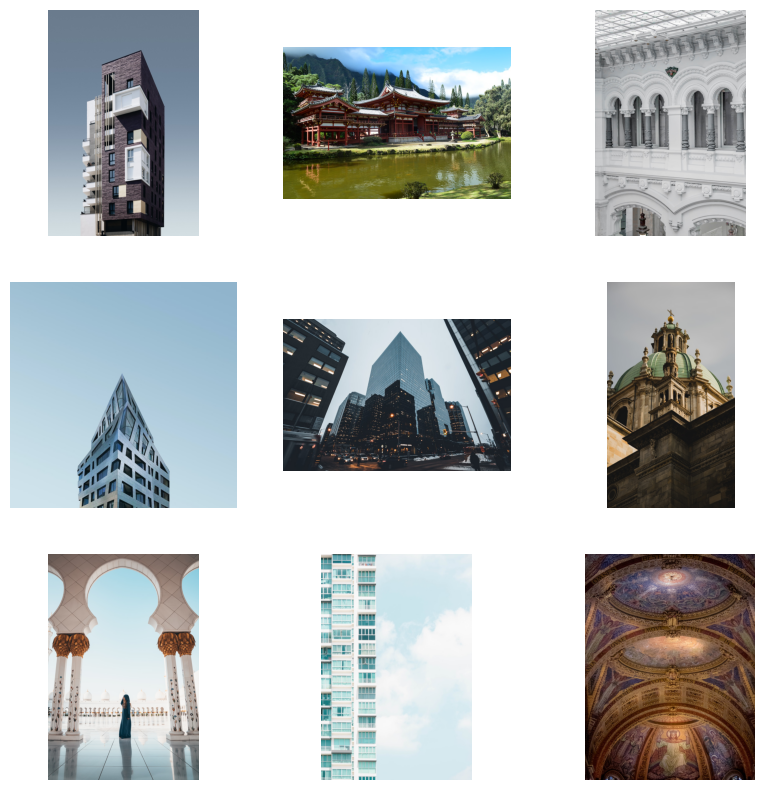

In [5]:
folder = 'drive/MyDrive/Pictures'
num_images = 9
grid_size = 3


all_files = os.listdir(folder)
image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
random_images = random.sample(image_files, num_images)
random_image_paths = [os.path.join(folder, img) for img in random_images]

fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

for idx, image_path in enumerate(random_image_paths):
    img = Image.open(image_path)
    row = idx // grid_size
    col = idx % grid_size
    axes[row, col].imshow(img)
    axes[row, col].axis('off')

plt.show()

# 2. Preposessing the data

In [17]:
# The batch size for training the data
batch = 8

# Determining the dimensions of the images to be 150x150 i.e. 1:1 ratio
image_size = 300

# Setting the path for the images
image_directory = "drive/MyDrive/Pictures/"

X = [] #Independent variable i.e. black and white image
y = [] #Target variable i.e. colour image

In [19]:
for image in os.listdir(image_directory):
    colour_img = Image.open(os.path.join(image_directory, image)).resize((image_size,image_size)) #Loading colour image and resizing it
    # Convert the RGB image to a NumPy array and then scale its pixel values to the range of [0,1]
    colour_img_array = (np.asarray(colour_img) ) / 255

    # Convert the image into black and white
    gray_image = colour_img.convert( 'L' )

    # Convert the B&W image to a NumPy array and then scale its pixel values to the range of [0,1]
    gray_image_array = ( np.asarray(gray_image).reshape((image_size, image_size, 1 ))) / 255

    # Append both the image arrays
    X.append(gray_image_array)
    y.append(colour_img_array)

In [21]:
# Split the dataset into training and testing sets
train_X, test_X, train_y, test_y = train_test_split( np.array(X) , np.array(y) , test_size=0.1 )

# Create a TensorFlow Dataset from the training data and labels and batch the dataset with the specified batch size
dataset = tf.data.Dataset.from_tensor_slices( ( train_X , train_y ) )
dataset = dataset.batch(batch)

# 3. Creating the Generative adversarial networks

## 3.1. Generator

In [ ]:
def generate_model(image_size=300):
    input_layer = tf.keras.layers.Input(shape=(image_size, image_size, 1))

    conv_block1 = tf.keras.layers.Conv2D(16, kernel_size=(5, 5), strides=1, padding='same')(input_layer)
    conv_block1 = tf.keras.layers.BatchNormalization()(conv_block1)
    conv_block1 = tf.keras.layers.ReLU()(conv_block1)
    conv_block1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=1, padding='same')(conv_block1)
    conv_block1 = tf.keras.layers.BatchNormalization()(conv_block1)
    conv_block1 = tf.keras.layers.ReLU()(conv_block1)
    conv_block1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=1, padding='same')(conv_block1)
    conv_block1 = tf.keras.layers.BatchNormalization()(conv_block1)
    conv_block1 = tf.keras.layers.ReLU()(conv_block1)

    conv_block2 = tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides=1, padding='same')(conv_block1)
    conv_block2 = tf.keras.layers.BatchNormalization()(conv_block2)
    conv_block2 = tf.keras.layers.ReLU()(conv_block2)
    conv_block2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=1, padding='same')(conv_block2)
    conv_block2 = tf.keras.layers.BatchNormalization()(conv_block2)
    conv_block2 = tf.keras.layers.ReLU()(conv_block2)
    conv_block2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=1, padding='same')(conv_block2)
    conv_block2 = tf.keras.layers.BatchNormalization()(conv_block2)
    conv_block2 = tf.keras.layers.ReLU()(conv_block2)

    conv_block3 = tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=1, padding='same')(conv_block2)
    conv_block3 = tf.keras.layers.BatchNormalization()(conv_block3)
    conv_block3 = tf.keras.layers.ReLU()(conv_block3)
    conv_block3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1, padding='same')(conv_block3)
    conv_block3 = tf.keras.layers.BatchNormalization()(conv_block3)
    conv_block3 = tf.keras.layers.ReLU()(conv_block3)
    conv_block3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1, padding='same')(conv_block3)
    conv_block3 = tf.keras.layers.BatchNormalization()(conv_block3)
    conv_block3 = tf.keras.layers.ReLU()(conv_block3)

    bottleneck_layer = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1, activation='sigmoid', padding='same')(conv_block3)

    concat_layer1 = tf.keras.layers.Concatenate()([bottleneck_layer, conv_block3])
    conv_up_block3 = tf.keras.layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(concat_layer1)
    conv_up_block3 = tf.keras.layers.BatchNormalization()(conv_up_block3)
    conv_up_block3 = tf.keras.layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(conv_up_block3)
    conv_up_block3 = tf.keras.layers.BatchNormalization()(conv_up_block3)
    conv_up_block3 = tf.keras.layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=1, padding='same', activation='relu')(conv_up_block3)

    concat_layer2 = tf.keras.layers.Concatenate()([conv_up_block3, conv_block2])
    conv_up_block2 = tf.keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(concat_layer2)
    conv_up_block2 = tf.keras.layers.BatchNormalization()(conv_up_block2)
    conv_up_block2 = tf.keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(conv_up_block2)
    conv_up_block2 = tf.keras.layers.BatchNormalization()(conv_up_block2)
    conv_up_block2 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(5, 5), strides=1, padding='same', activation='relu')(conv_up_block2)

    concat_layer3 = tf.keras.layers.Concatenate()([conv_up_block2, conv_block1])
    conv_up_block1 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(concat_layer3)
    conv_up_block1 = tf.keras.layers.BatchNormalization()(conv_up_block1)
    conv_up_block1 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(conv_up_block1)
    conv_up_block1 = tf.keras.layers.BatchNormalization()(conv_up_block1)
    conv_up_block1 = tf.keras.layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=1, padding='same', activation='relu')(conv_up_block1)

    model = tf.keras.models.Model(input_layer, conv_up_block1)
    return model


## 3.2. Discriminator 

In [ ]:
def patchgan_discriminator(image_size=300):
    layers = [
        tf.keras.layers.Conv2D(32, kernel_size=(7, 7), strides=1, padding='same', activation='relu', input_shape=(image_size, image_size, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, kernel_size=(7, 7), strides=1, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=1, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=1, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]
    model = tf.keras.models.Sequential(layers)
    return model

## 3.3. Loss Function

In [ ]:
binary_crossentropy = tf.keras.losses.BinaryCrossentropy()
mean_squared_err = tf.keras.losses.MeanSquaredError()

def discriminator_cost(real_predictions, generated_predictions):
    real_loss_val = binary_crossentropy(tf.ones_like(real_predictions) - tf.random.uniform(shape=real_predictions.shape, maxval=0.1), real_predictions)
    generated_loss_val = binary_crossentropy(tf.zeros_like(generated_predictions) + tf.random.uniform(shape=generated_predictions.shape, maxval=0.1), generated_predictions)
    combined_loss = real_loss_val + generated_loss_val
    return combined_loss

def generator_cost(generated_predictions, true_labels):
    true_labels = tf.cast(true_labels, 'float32')
    return mean_squared_err(generated_predictions, true_labels)


generator_optimizer = tf.keras.optimizers.Adam( 0.0005 )
discriminator_optimizer = tf.keras.optimizers.Adam( 0.0005 )

generator = generate_model()
discriminator = patchgan_discriminator()

# 4. Training the Model

In [ ]:
def save_generated_images(epoch, generator, test_X):
    # Generate images from the test dataset
    generated_images = generator.predict(test_X)
    generated_images = np.clip(generated_images, 0, 1)  # for float values
    generated_images = np.clip(generated_images * 255, 0, 255).astype('uint8')  # for integer values


    # Prepare the plot
    plt.figure(figsize=(8, 8))
    num_images = min(16, generated_images.shape[0])  # Limit the number of images to 16
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')

    # Save the plot
    plt.savefig(f'Generated/generated_images_epoch_{epoch}.png')
    plt.close()


In [ ]:
@tf.function
def train_step(input_data, true_data):
   
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        # Generate an image -> G(x)
        generated_images = generator(input_data, training=True)
        # Probability that the given image is real -> D(x)
        real_probabilities = discriminator(true_data, training=True)
        # Probability that the given image is the one generated -> D(G(x))
        generated_probabilities = discriminator(generated_images, training=True)
        
        # L2 Loss -> ||y - G(x)||^2
        generator_error = generator_cost(generated_images, true_data)
        # Log loss for the discriminator
        discriminator_error = discriminator_cost(real_probabilities, generated_probabilities)
    
    # Compute the gradients
    generator_gradients = generator_tape.gradient(generator_error, generator.trainable_variables)
    discriminator_gradients = discriminator_tape.gradient(discriminator_error, discriminator.trainable_variables)

    # Optimize with Adam
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return generator_error, discriminator_error

In [ ]:
epochs = 300

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    epoch_gen_loss = 0
    epoch_disc_loss = 0
    batch_count = 0

    for (X, y) in dataset:
        # Here (x, y) represents a batch from our training dataset.
        gen_loss, disc_loss = train_step(X, y)
        epoch_gen_loss += gen_loss
        epoch_disc_loss += disc_loss
        batch_count += 1

    avg_gen_loss = epoch_gen_loss / batch_count
    avg_disc_loss = epoch_disc_loss / batch_count
    print(f"Generator Loss: {avg_gen_loss}, Discriminator Loss: {avg_disc_loss}")

    # Save generated images every 5 epochs
    if epoch % 15 == 0:
        save_generated_images(epoch, generator, test_X)

Epoch 1/300
Generator Loss: 0.026875536888837814, Discriminator Loss: 1.1261723041534424
5/5 [==============================] - 18s 2s/step
Epoch 2/300
Generator Loss: 0.010695558972656727, Discriminator Loss: 0.9199404716491699
Epoch 3/300
Generator Loss: 0.009517678059637547, Discriminator Loss: 1.0667232275009155
Epoch 4/300
Generator Loss: 0.009087360464036465, Discriminator Loss: 1.0487751960754395
Epoch 5/300
Generator Loss: 0.008815912529826164, Discriminator Loss: 0.8745208978652954
Epoch 6/300
Generator Loss: 0.008558138273656368, Discriminator Loss: 0.9594729542732239
Epoch 7/300
Generator Loss: 0.008492492139339447, Discriminator Loss: 0.9171907305717468
Epoch 8/300
Generator Loss: 0.008272966369986534, Discriminator Loss: 0.9350010752677917
Epoch 9/300
Generator Loss: 0.008132167160511017, Discriminator Loss: 0.9462346434593201
Epoch 10/300
Generator Loss: 0.008113833144307137, Discriminator Loss: 0.9512324333190918
Epoch 11/300
Generator Loss: 0.008035097271203995, Discrim

In [ ]:
# Load the test image dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_X, test_y))
test_dataset = test_dataset.batch(batch)

# Generate colorized images using the trained model on the test images
generated_images = generator.predict(test_X)

5/5 [==============================] - 1s 159ms/step


In [ ]:
# Create a graph to compare the black and white input image, the output colorized image, and the original ground truth color image
for i in range(len(test_X[0:50])):
    plt.figure(figsize=(10,10))

    greyscale_image = plt.subplot(3,3,1)
    greyscale_image.set_title('B&W Input', fontsize=14)
    plt.imshow(test_X[i].reshape((image_size, image_size)), cmap='gray')

    colorized_image = plt.subplot(3,3,2)    
    colorized_image.set_title('Colorized Output', fontsize=14)
    plt.imshow(generated_images[i])

    original_image = plt.subplot(3,3,3)
    original_image.set_title('Original Image', fontsize=14)
    plt.imshow(test_y[i])

    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Save the generator model
generator.save('generator_model.h5')

1/1 [==============================] - 1s 999ms/step


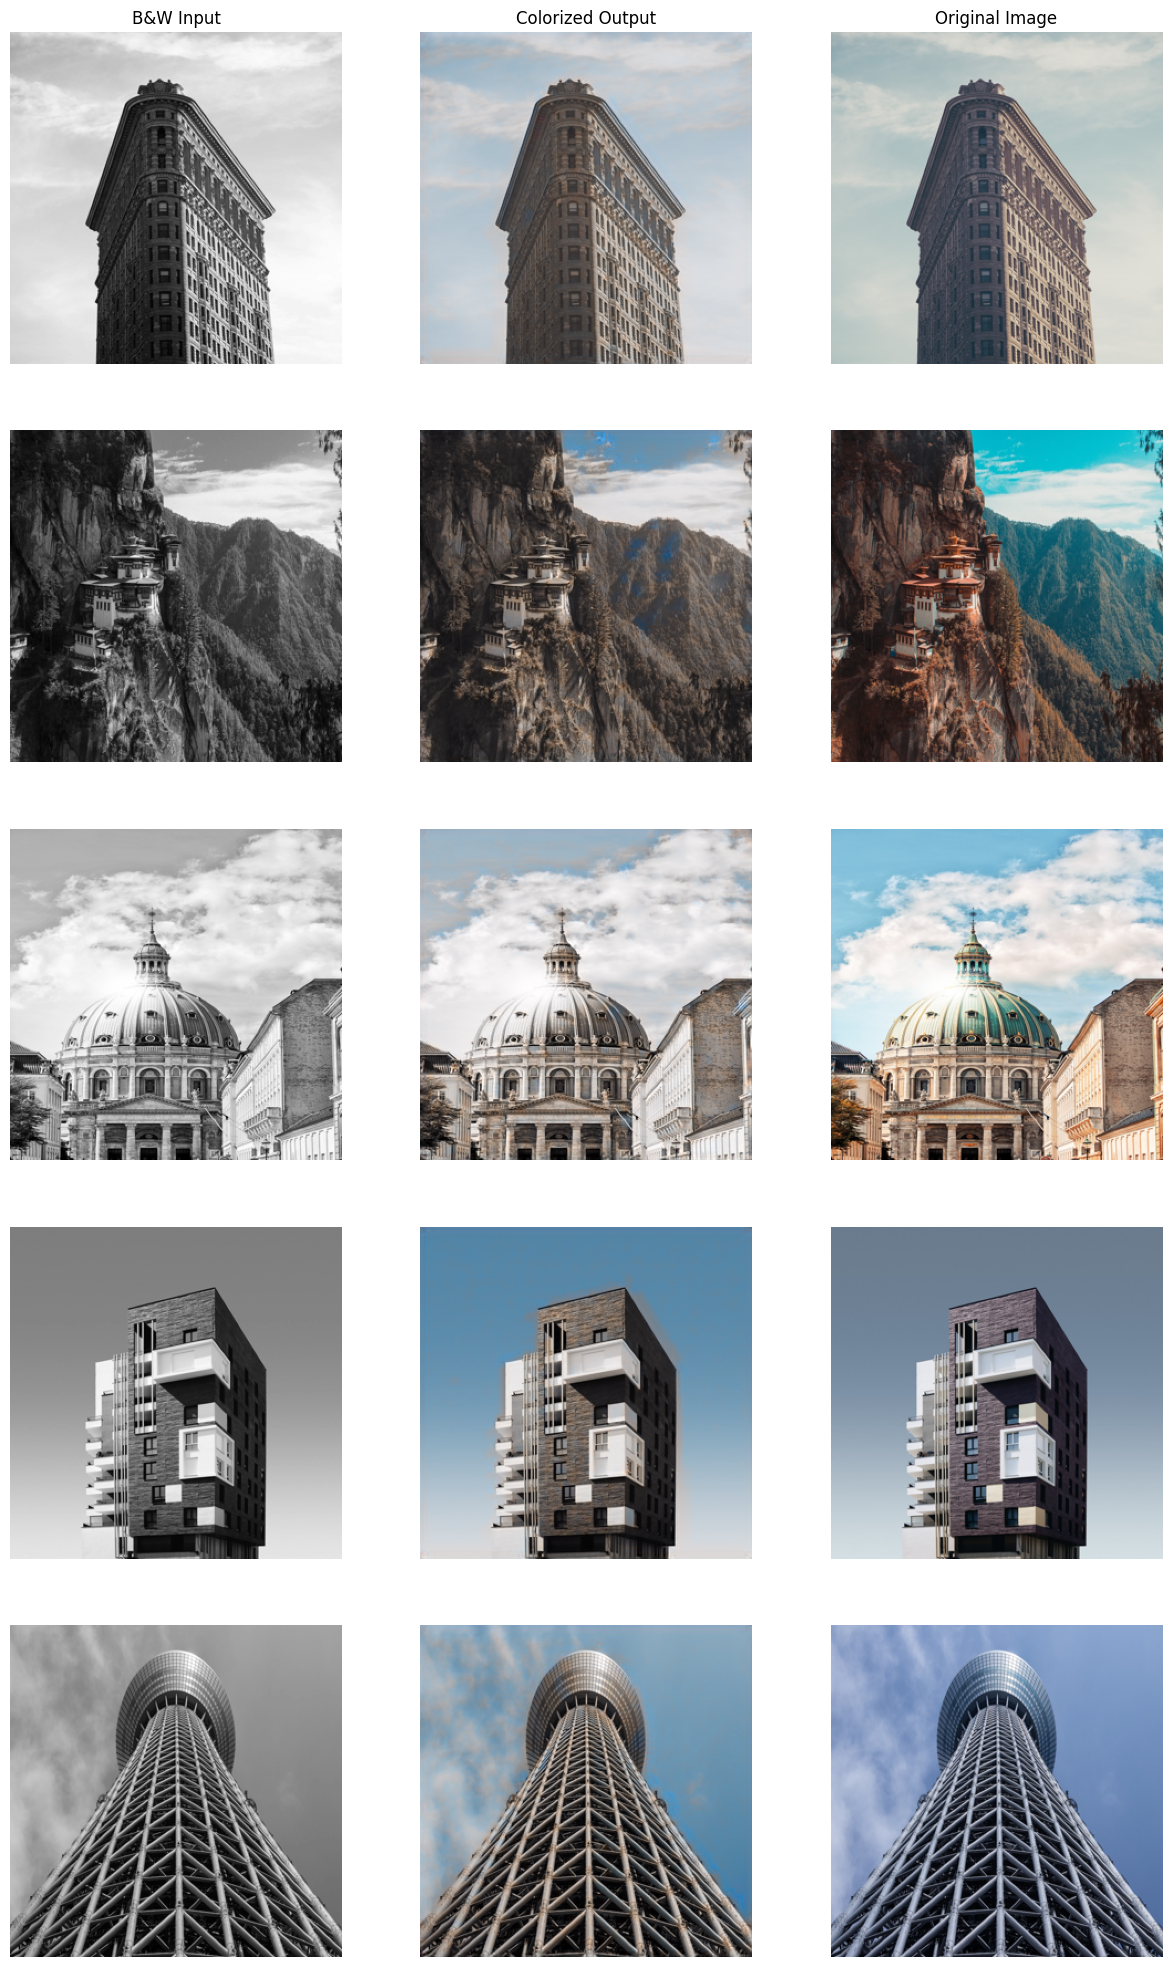

In [21]:
# Load the generator model
generator = load_model('generator_model.h5')

# Select 4 random images
image_size = 300
num_images = 5

all_files = os.listdir(folder)
image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

random_images = random.sample(image_files, num_images)
random_image_paths = [os.path.join(folder, img) for img in random_images]

plt.figure(figsize=(15, 5 * num_images))

for idx, image_path in enumerate(random_image_paths):
    # Load the image
    color_img = Image.open(image_path).resize((image_size, image_size))
    gray_image = color_img.convert('L')

    # Preprocess the grayscale image
    gray_image_array = (np.asarray(gray_image).reshape((1, image_size, image_size, 1))) / 255

    # Colorize the grayscale image using the generator model
    generated_image = generator.predict(gray_image_array)
    generated_image = np.clip(generated_image, 0, 1)
    generated_image = (generated_image * 255).astype('uint8')
    generated_image = Image.fromarray(generated_image[0])

    # Display the grayscale image, colorized image, and original image
    plt.subplot(num_images, 3, 3 * idx + 1)
    plt.imshow(gray_image, cmap='gray')
    if idx == 0:
        plt.title('B&W Input')
    plt.axis('off')

    plt.subplot(num_images, 3, 3 * idx + 2)
    plt.imshow(generated_image)
    if idx == 0:
        plt.title('Colorized Output')
    plt.axis('off')

    plt.subplot(num_images, 3, 3 * idx + 3)
    plt.imshow(color_img)
    if idx == 0:
        plt.title('Original Image')
    plt.axis('off')

plt.show()

1/1 [==============================] - 0s 264ms/step


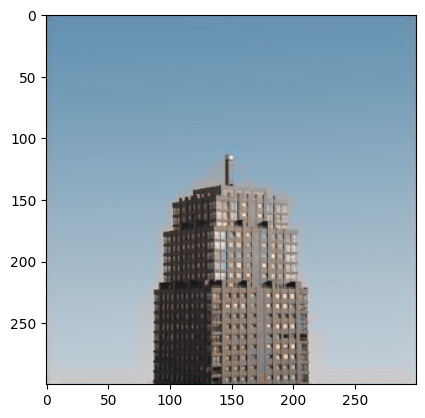

In [14]:
generator = load_model('drive/MyDrive/generator_model.h5')
image_size = 300

# Load a greyscale image
gray_image = Image.open('drive/MyDrive/Pictures/Image-129.jpg').convert('L').resize((image_size, image_size))
gray_image_array = (np.asarray(gray_image).reshape((1, image_size, image_size, 1))) / 255

# Colorize the image
colorized_image = generator.predict(gray_image_array)

# Display the colorized image
plt.imshow(colorized_image[0])

In [23]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image



generated_images = generator.predict(test_X)

def calculate_ssim(original, generated):
    return ssim(original, generated, multichannel=True)

def calculate_psnr(original, generated):
    return psnr(original, generated, data_range=generated.max() - generated.min())

def calculate_mse(original, generated):
    return np.mean((original - generated) ** 2)

ssim_scores = []
psnr_scores = []
mse_scores = []

for i in range(len(test_y)):
    original_image = test_y[i]
    generated_image = generated_images[i]

    ssim_score = calculate_ssim(original_image, generated_image)
    psnr_score = calculate_psnr(original_image, generated_image)
    mse_score = calculate_mse(original_image, generated_image)

    ssim_scores.append(ssim_score)
    psnr_scores.append(psnr_score)
    mse_scores.append(mse_score)

print(mse_scores)
print(psnr_scores)
print(ssim_scores)

5/5 [==============================] - 18s 2s/step


<ipython-input-23-258171c22678>:13: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return ssim(original, generated, multichannel=True)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


[0.0070600297375059485, 0.005299230735584218, 0.00033553137423373235, 0.003781987958535122, 0.005903650191148542, 0.001857595869621995, 0.0017387427536857069, 0.0009961766452662854, 0.002368952834866805, 0.0016195088444926331, 0.0008563238320784015, 0.0011522331660495603, 0.0007673405921872252, 0.002072175861213539, 0.00772901467112027, 0.01702734795058568, 0.002035965133109678, 0.000523463688721804, 0.003565605706090893, 0.005905658354894315, 0.0005107802832940797, 0.011055600860710084, 0.0026663381096231546, 0.0008079245721715257, 0.0012411323462762607, 0.0037153766145882586, 0.001096680544672871, 0.0010920544159395014, 0.0008059124048287175, 0.00031366743611273984, 0.005441312971051603, 0.0004031382715708033, 0.011002479079512364, 0.010351447015262688, 0.006720967643189336, 0.002416501967535136, 0.004025912489901001, 0.002663043435766379, 0.0009597452906806056, 0.002049530389583817, 0.0008773592945508333, 0.014492540536432705, 0.003589380663150237, 0.002132496753048834, 0.0016269018

In [ ]:
!pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


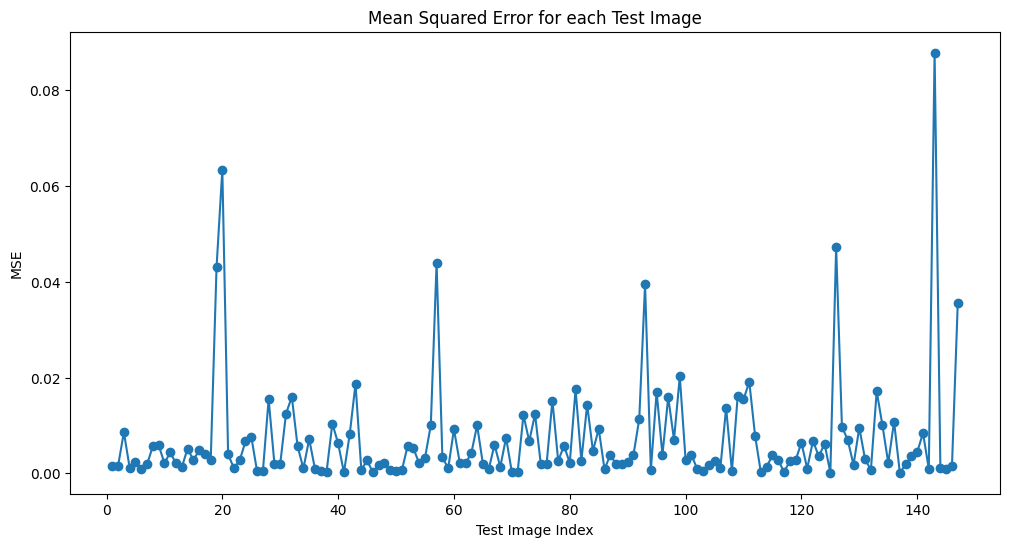

Mean MSE: 0.007153657085154662
Standard Deviation of MSE: 0.011628406624385494


In [ ]:
from sklearn.metrics import mean_squared_error

mse_values = []
for i in range(len(test_X)):
    mse = mean_squared_error(test_y[i].flatten(), generated_images[i].flatten())
    mse_values.append(mse)

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(test_X) + 1), mse_values, marker='o')
plt.xlabel('Test Image Index')
plt.ylabel('MSE')
plt.title('Mean Squared Error for each Test Image')
plt.show()

print("Mean MSE:", np.mean(mse_values))
print("Standard Deviation of MSE:", np.std(mse_values))

In [ ]:
def calculate_ssim(original, generated):
    return ssim(original, generated, multichannel=True)

def calculate_psnr(original, generated):
    return psnr(original, generated, data_range=generated.max() - generated.min())

def calculate_mse(original, generated):
    return np.mean((original - generated) ** 2)

In [ ]:
# Initialize the lists to store the metrics
ssim_scores = []
psnr_scores = []
mse_scores = []

# Iterate through the generated images and calculate the metrics
for i in range(len(test_y)):
    original_image = test_y[i]
    generated_image = generated_images[i]

    ssim_score = calculate_ssim(original_image, generated_image)
    psnr_score = calculate_psnr(original_image, generated_image)
    mse_score = calculate_mse(original_image, generated_image)

    ssim_scores.append(ssim_score)
    psnr_scores.append(psnr_score)
    mse_scores.append(mse_score)

# Calculate the average of each metric
avg_ssim = np.mean(ssim_scores)
avg_psnr = np.mean(psnr_scores)
avg_mse = np.mean(mse_scores)

# Print the results
print(f"Average SSIM: {avg_ssim}")
print(f"Average PSNR: {avg_psnr}")
print(f"Average MSE: {avg_mse}")

<ipython-input-68-65dfb83540cd>:6: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return ssim(original, generated, multichannel=True)


Average SSIM: 0.9455294577015596
Average PSNR: 24.88812857020592
Average MSE: 0.007153657085154662


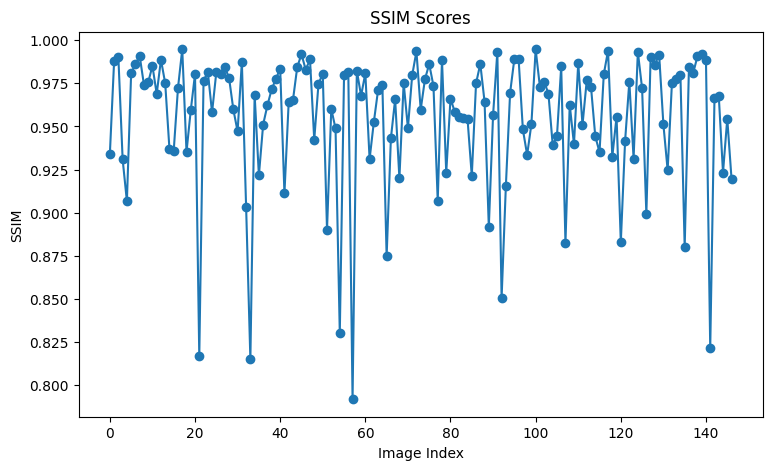

<Figure size 640x480 with 0 Axes>

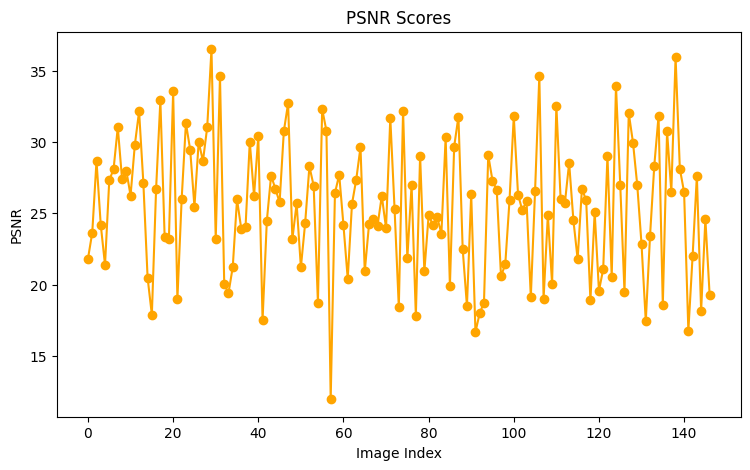

<Figure size 640x480 with 0 Axes>

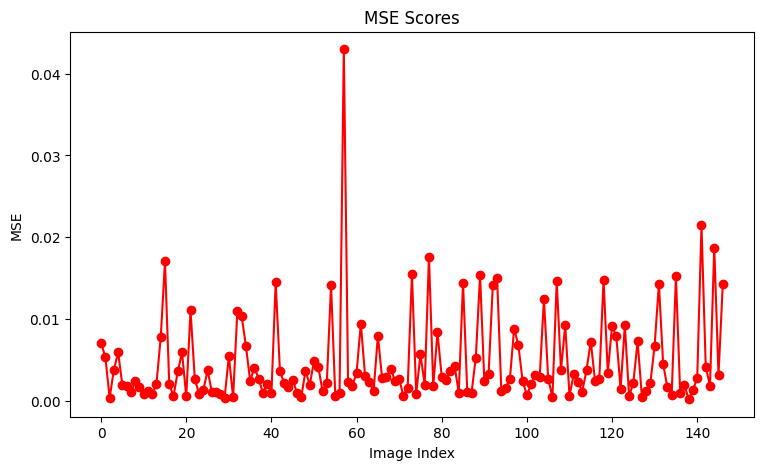

<Figure size 640x480 with 0 Axes>

In [24]:
# Plot the metrics
plt.figure(figsize=(30, 5))

plt.subplot(1, 3, 1)
plt.plot(ssim_scores, label='SSIM', marker='o')
plt.xlabel('Image Index')
plt.ylabel('SSIM')
plt.title('SSIM Scores')

plt.show()
plt.clf()

plt.figure(figsize=(30, 5))
plt.subplot(1, 3, 2)
plt.plot(psnr_scores, label='PSNR', color='orange', marker='o')
plt.xlabel('Image Index')
plt.ylabel('PSNR')
plt.title('PSNR Scores')

plt.show()
plt.clf()

plt.figure(figsize=(30, 5))
plt.subplot(1, 3, 3)
plt.plot(mse_scores, label='MSE', color='red', marker='o')
plt.xlabel('Image Index')
plt.ylabel('MSE')
plt.title('MSE Scores')

plt.show()
plt.clf()